In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import pickle

from tqdm import tqdm

from collections import Counter

from linearization.analyzer import SAELinearizer
from linearization.visualization import visualize_topk

In [3]:
EXPANSION_FACTOR = 64

In [4]:
# OVERRIDE = True
OVERRIDE = False

path = f"../data/pickled_linearizers/gelu_2l_{EXPANSION_FACTOR}.pkl"

# sae_names = [
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer0/seed42_ln2_normalized/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer0/seed42_mlp_out/final_sparse_autoencoder_gelu-2l_blocks.0.hook_mlp_out_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer0/seed42_transcoder/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer1/seed42_ln2_normalized/final_sparse_autoencoder_gelu-2l_blocks.1.ln2.hook_normalized_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer1/seed42_mlp_out/final_sparse_autoencoder_gelu-2l_blocks.1.hook_mlp_out_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer1/seed42_transcoder/final_sparse_autoencoder_gelu-2l_blocks.1.ln2.hook_normalized_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer0/seed43_ln2_normalized/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer0/seed43_mlp_out/final_sparse_autoencoder_gelu-2l_blocks.0.hook_mlp_out_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer0/seed43_transcoder/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer1/seed43_ln2_normalized/final_sparse_autoencoder_gelu-2l_blocks.1.ln2.hook_normalized_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer1/seed43_mlp_out/final_sparse_autoencoder_gelu-2l_blocks.1.hook_mlp_out_16384.pt",
#     f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer1/seed43_transcoder/final_sparse_autoencoder_gelu-2l_blocks.1.ln2.hook_normalized_16384.pt",
# ]

# Automated SAE name generation
seeds = [42, 43]
layers = [0, 1]
names1 = ["ln2_normalized", "mlp_out", "transcoder"]
names2 = ["ln2.hook_normalized", "hook_mlp_out", "ln2.hook_normalized"]

sae_names = []
for seed in seeds:
    for layer in layers:
        for name1, name2 in zip(names1, names2):
            sae_names.append(
                f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer{layer}/seed{seed}_{name1}/final_sparse_autoencoder_gelu-2l_blocks.{layer}.{name2}_{512 * EXPANSION_FACTOR}.pt"
            )

if os.path.exists(path) and not OVERRIDE:
    lin = pickle.load(open(path, "rb"))
else:
    lin = SAELinearizer(
        model_name="gelu-2l",
        sae_names=sae_names,
        layers=[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        dataset_name="NeelNanda/pile-10k",
        act_name="normalized",
        num_batches=10,
        half_precision=False,
        # transcoder=True,
        # use_gpt=True,
        # dict_mult=64,
        # hook_point="resid_mid",
        run_analysis=True,
    )
    with open(path, "wb") as f:
        pickle.dump(lin, f)

In [5]:
# 5 features, uniformly sampled by frequency, seed 42 layer 0:

# sae_name = "../scripts/checkpoints/32x_gelu_2l/layer0/seed42_transcoder/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt"
LAYER = 1
SEED = 42
sae_name = f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_2l/layer{LAYER}/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-2l_blocks.{LAYER}.ln2.hook_normalized_{512 * EXPANSION_FACTOR}.pt"
freqs = lin.frequencies[sae_name]

my_sample = np.argsort(freqs.cpu().numpy())[::-1][:: len(freqs) // 5]
print(" ".join([f"{x}: {freqs[x].item()}" for x in my_sample]))

10563: 0.27000734210014343 22537: 0.002905273577198386 20889: 0.0006591796991415322 21770: 0.00019531250291038305 241: 0.0 21470: 0.0


In [6]:
def set_and_visualize(feature_idx, l=0, num_batches=10):
    lin.set_feature(feature_idx, sae_name, num_batches=num_batches)

    fig, axs = plt.subplots(2, 1, figsize=(20, 10))

    ax = visualize_topk(
        examples=lin.top_examples["examples"].detach().cpu().numpy(),
        activations=lin.top_examples["activations"].detach().cpu().numpy(),
        columns=lin.top_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[0],
    )
    axs[0].set_title(f"Top activating examples")

    ax = visualize_topk(
        examples=lin.uniform_ranked_examples["examples"].detach().cpu().numpy(),
        activations=lin.uniform_ranked_examples["activations"].detach().cpu().numpy(),
        columns=lin.uniform_ranked_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[1],
    )
    axs[1].set_title(f"Uniform examples")

    fig.suptitle(f"Feature {feature_idx} in layer {l}, sparsity: {100*lin.frequencies[sae_name][feature_idx]:.3f}%")

    plt.tight_layout()
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 30.57it/s]
/tmp/ipykernel_694561/2999266918.py:30: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/home/phil/miniconda3/envs/mats/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


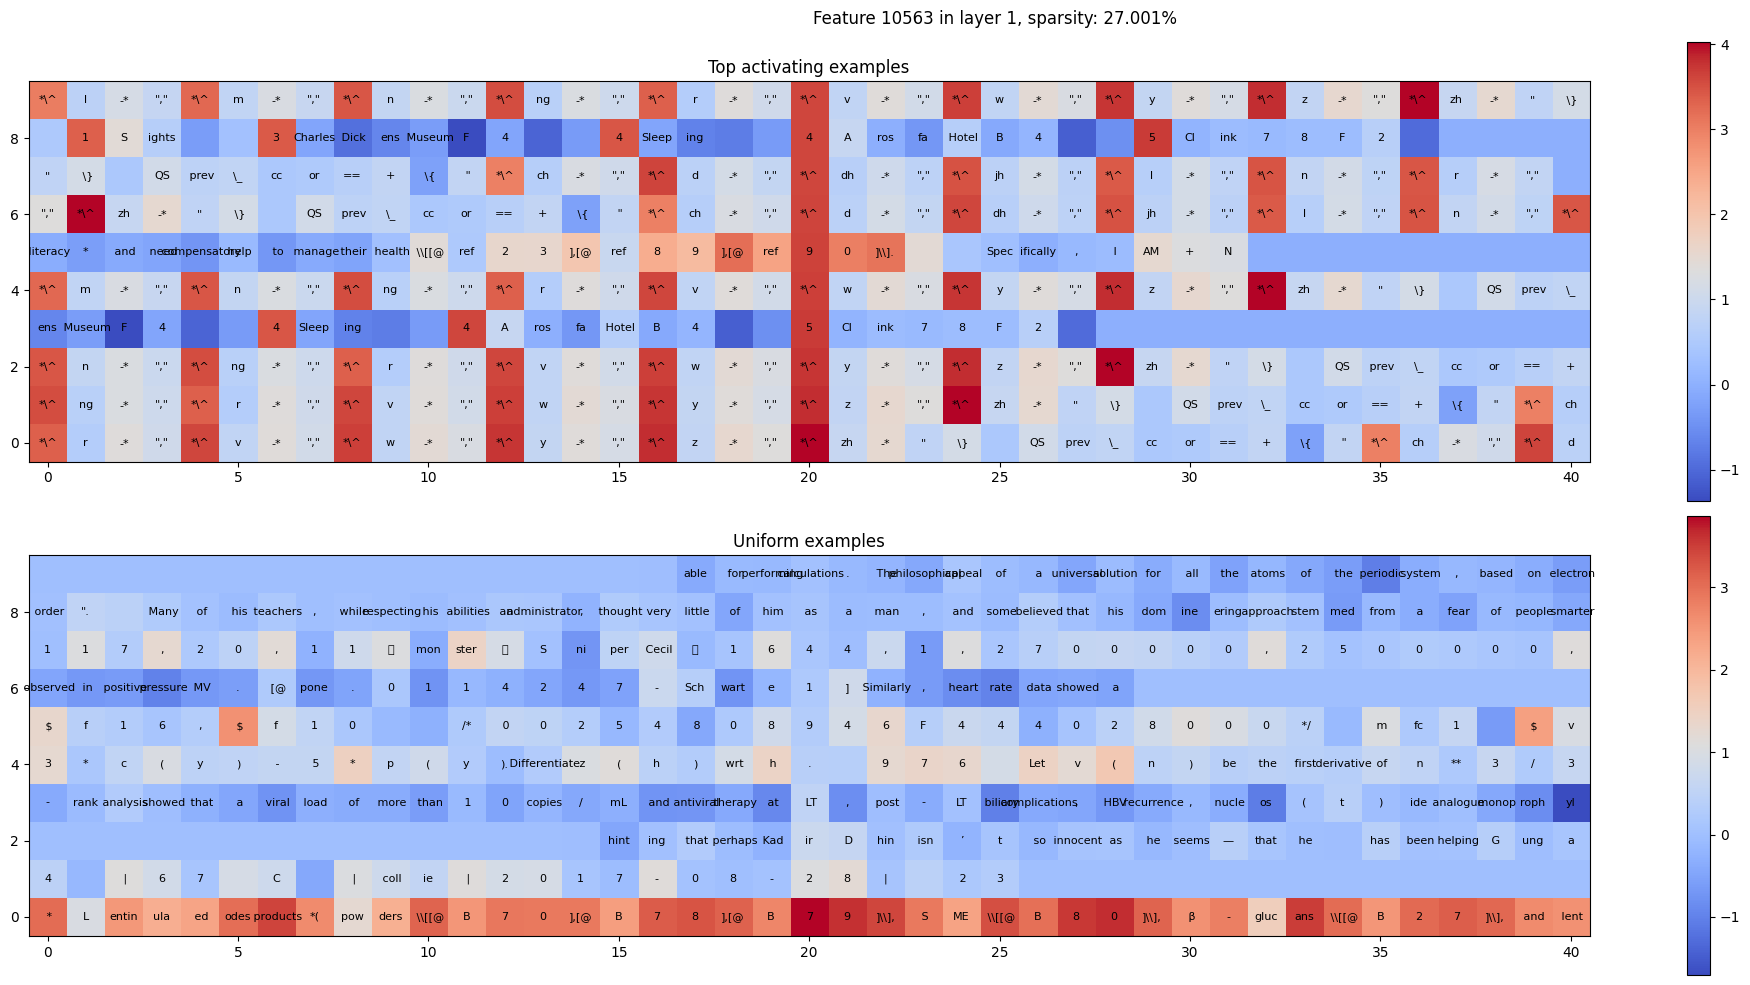

In [7]:
set_and_visualize(my_sample[0], l=LAYER)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 32.35it/s]
) missing from current font.6918.py:30: UserWarning: Glyph 13 (
  plt.tight_layout()
/tmp/ipykernel_694561/2999266918.py:30: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_694561/2999266918.py:30: UserWarning: Glyph 22580 (\N{CJK UNIFIED IDEOGRAPH-5834}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_694561/2999266918.py:30: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_694561/2999266918.py:30: UserWarning: Glyph 19990 (\N{CJK UNIFIED IDEOGRAPH-4E16}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_694561/2999266918.py:30: UserWarning: Glyph 30028 (\N{CJK UNIFIED IDEOGRAPH-754C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_694561/2999266918.py:30: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from current font.
  plt.tight_layout()
/tmp/ip

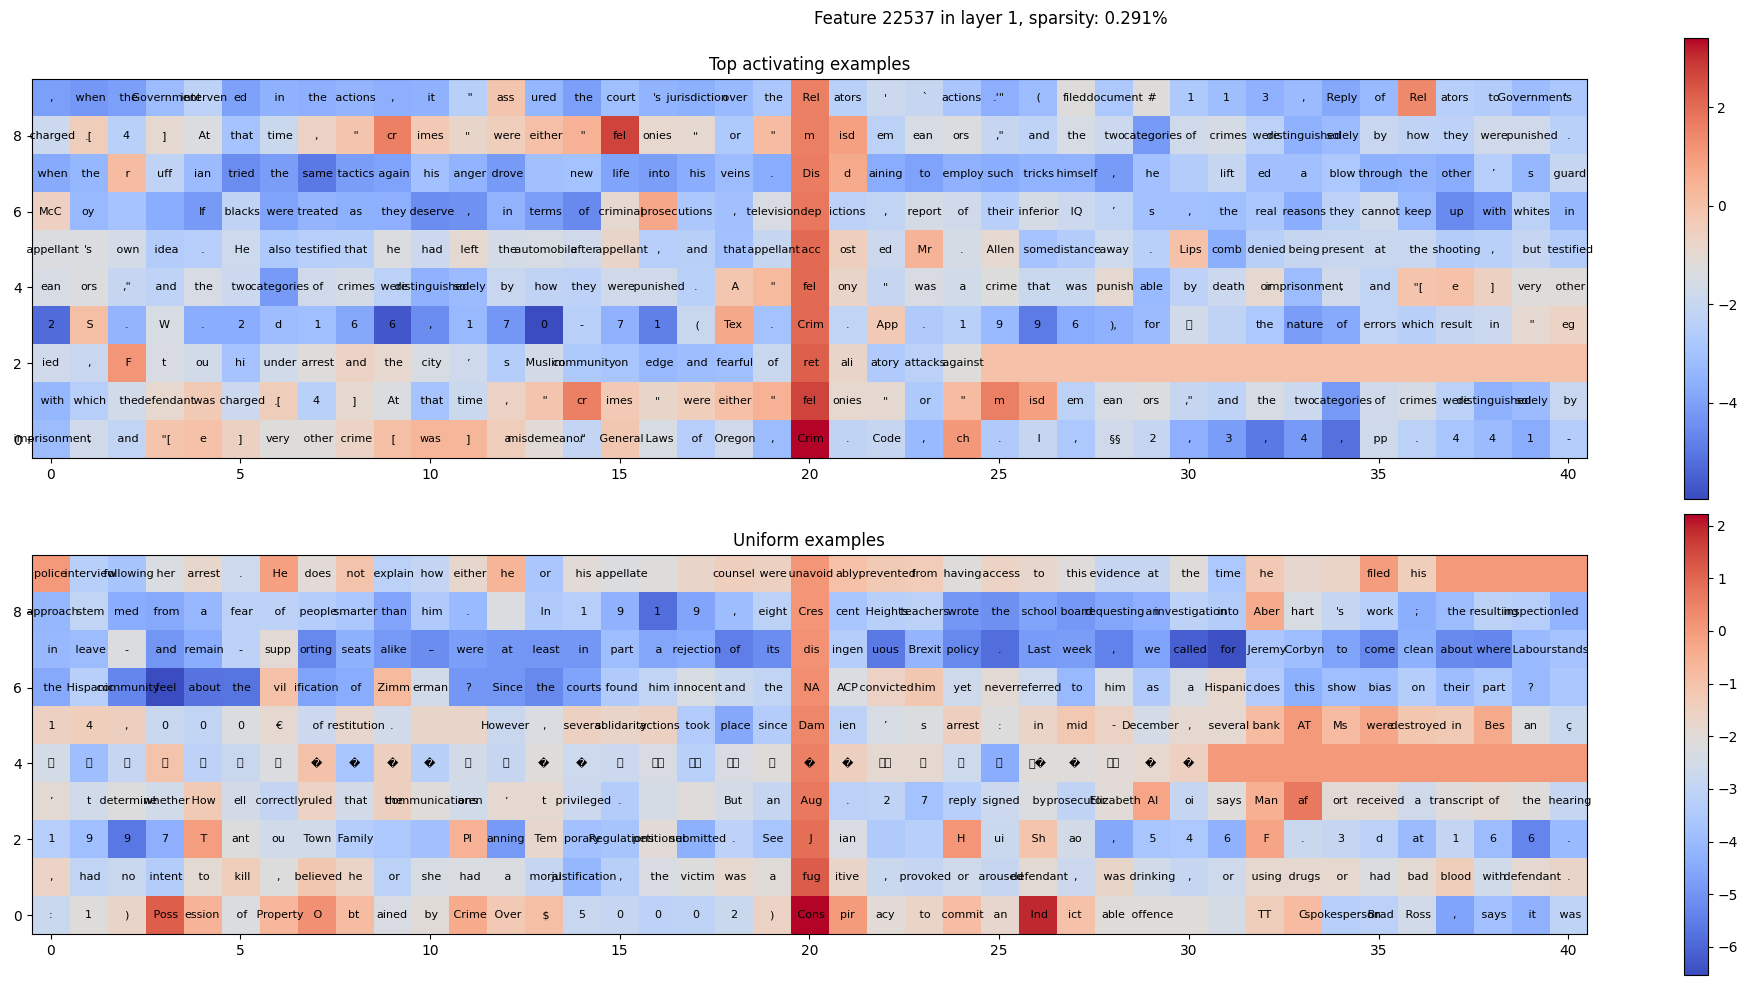

In [8]:
set_and_visualize(my_sample[1], l=LAYER)

 40%|████      | 4/10 [00:00<00:00, 29.59it/s]

100%|██████████| 10/10 [00:00<00:00, 30.35it/s]


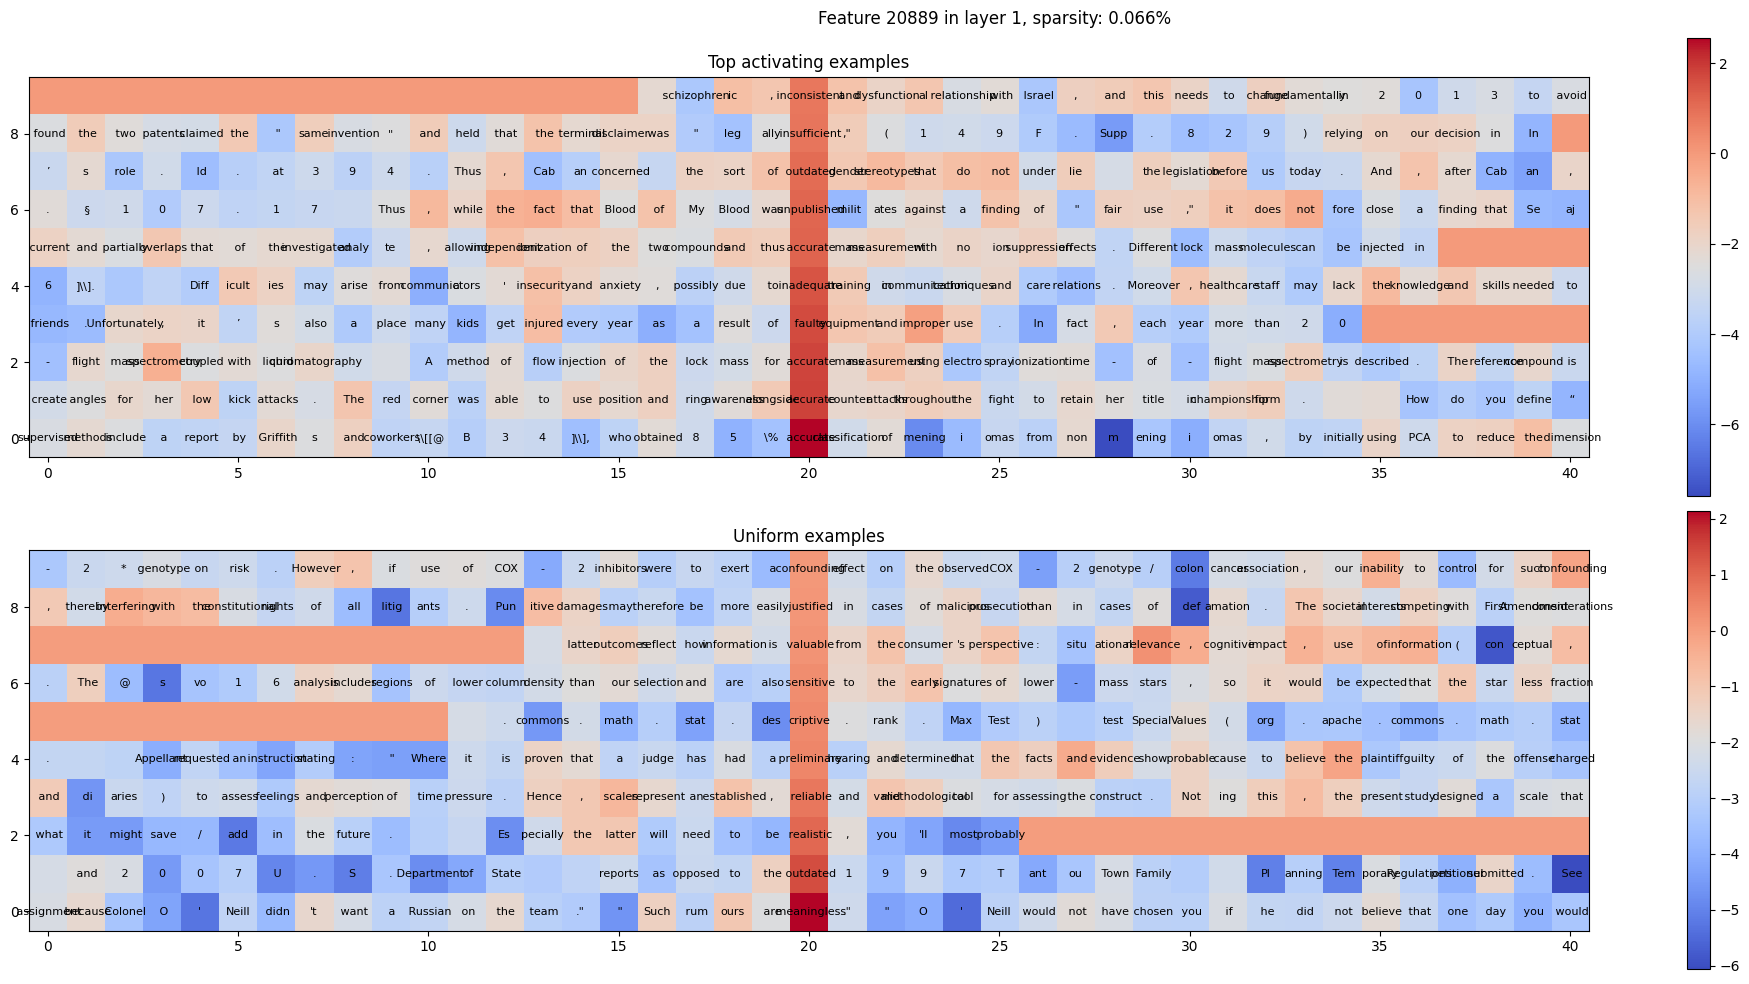

In [9]:
set_and_visualize(my_sample[2], l=LAYER)

 30%|███       | 3/10 [00:00<00:00, 26.67it/s]

100%|██████████| 10/10 [00:00<00:00, 26.92it/s]


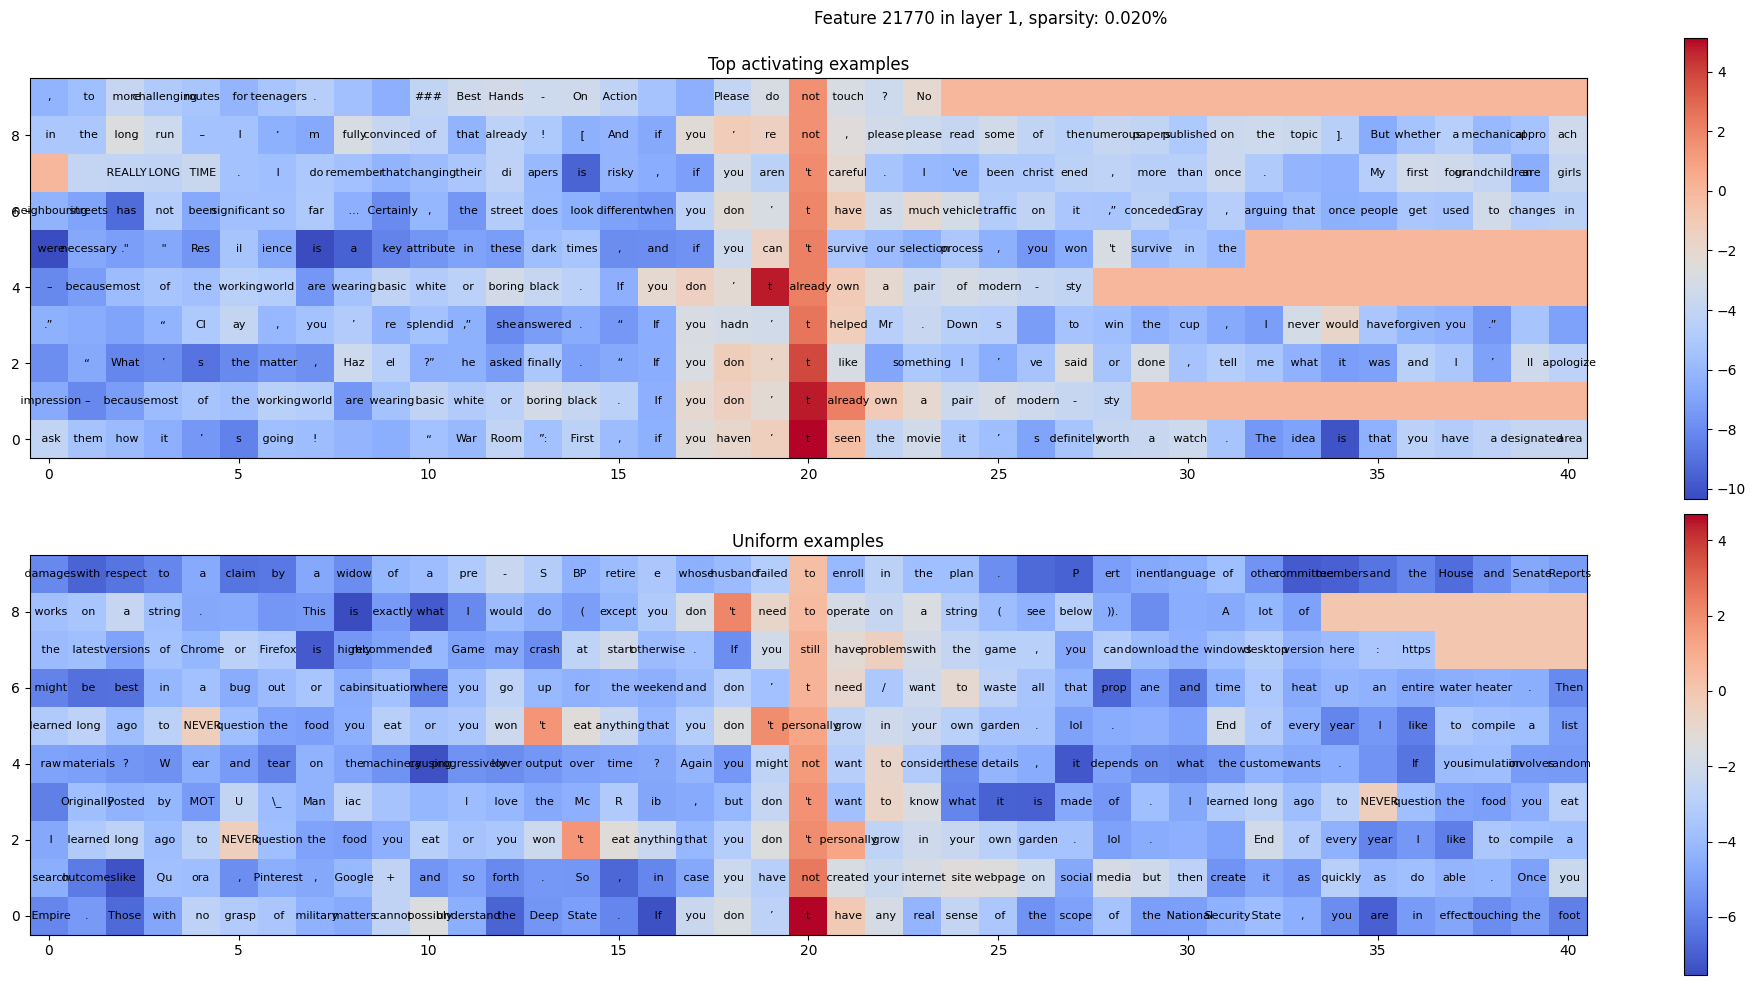

In [10]:
set_and_visualize(my_sample[3], l=LAYER)

In [17]:
lin.offload_to_cpu()
lin.model = lin.model.half()
lin.data = lin.data.half()
lin.saes = {k: v.half() for k, v in lin.saes.items()}
set_and_visualize(my_sample[4], l=LAYER, num_batches=20)

  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: expected scalar type Half but found Float